<a href="https://colab.research.google.com/github/shill7/APS360_Project/blob/main/Project_Sophia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install contractions
%pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import random
from sklearn.model_selection import train_test_split
import shutil
import string
import re

import pandas as pd
import contractions
import re
import nltk
from nltk.tokenize import word_tokenize
from datasketch import MinHash, MinHashLSH
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('cmudict')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [ ]:
from nltk.corpus import cmudict
d = cmudict.dict()

## **Preprocessing and Splitting Dataset**

In [ ]:
def clean_text(text):
  # Expand contractions
  text = contractions.fix(text)

  # Remove non-alphabelic/numeric symbols except basic punctuations
  text = re.sub(r'[^\w\s.,!?\'":;()]', '', text)

  # Normalize whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Lowercase
  text = text.lower()

  # Remove short text
  if len(text.split()) < 350 or len(nltk.sent_tokenize(text)) < 2:
    return None

  return text

def deduplication(df, text_col='text_clean', threshold=0.9, num_perm=128):
  # Initialize MinHashLSH
  lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
  minhashes = {}

  # Creating MinHash and LSH index
  for idx, text in df[text_col].items():
    tokens = set(word_tokenize(text))
    m = MinHash(num_perm=num_perm)
    for token in tokens:
      m.update(token.encode('utf8'))
    lsh.insert(idx, m)
    minhashes[idx] = m

  # Finding duplicates
  remove_data = set()
  for idx in df.index:
    if idx in remove_data:
      continue
    near_dupes = lsh.query(minhashes[idx])
    near_dupes = [i for i in near_dupes if i != idx]
    remove_data.update(near_dupes)

  deduped_df = df.drop(index=remove_data)
  return deduped_df

In [ ]:
def splitDataset(data_path):
  # Reading dataset
  df = pd.read_csv(os.path.join(data_path, 'Kaggle', 'AI_Human.csv'))

  # Clean
  df_cleaned = df.copy()
  df_cleaned['text_clean'] = df_cleaned['text'].apply(clean_text)
  df_cleaned = df_cleaned.dropna(subset=['text_clean'])
  print(f"Remaining data after cleaning: {len(df_cleaned)}")

  # Deduplication
  df_deduped = deduplication(df_cleaned)
  print(f"Remaining data after deduplication: {len(df_deduped)}")

  human_df = df_deduped[df_deduped['generated'] == 0]
  ai_df = df_deduped[df_deduped['generated'] == 1]

  # Getting preprocessed text for human and AI
  human_text = human_df['text_clean']
  ai_text = ai_df['text_clean']

  # Train/Temp Split (70% train, 30% temp)
  human_train, human_temp = train_test_split(human_text, test_size=0.30, random_state=42)
  ai_train, ai_temp = train_test_split(ai_text, test_size=0.30, random_state=42)
  # Val/Test Split (30% temp --> 15% Val, 15% Test)
  human_val, human_test = train_test_split(human_temp, test_size=0.50, random_state=42)
  ai_val, ai_test = train_test_split(ai_temp, test_size=0.50, random_state=42)

  # Save to CSV files
  human_train.to_csv(os.path.join(data_path, 'human_train.csv'), index=False, header=True)
  human_val.to_csv(os.path.join(data_path, 'human_val.csv'), index=False, header=True)
  human_test.to_csv(os.path.join(data_path, 'human_test.csv'), index=False, header=True)

  ai_train.to_csv(os.path.join(data_path, 'ai_train.csv'), index=False, header=True)
  ai_val.to_csv(os.path.join(data_path, 'ai_val.csv'), index=False, header=True)
  ai_test.to_csv(os.path.join(data_path, 'ai_test.csv'), index=False, header=True)


In [ ]:
def loadTrainValTestData(data_path):
  # Load data
  human_train = pd.read_csv(os.path.join(data_path, 'human_train.csv'))
  human_val = pd.read_csv(os.path.join(data_path,'human_val.csv'))
  human_test = pd.read_csv(os.path.join(data_path,'human_test.csv'))
  ai_train = pd.read_csv(os.path.join(data_path, 'ai_train.csv'))
  ai_val = pd.read_csv(os.path.join(data_path, 'ai_val.csv'))
  ai_test = pd.read_csv(os.path.join(data_path, 'ai_test.csv'))

  # Add labels
  human_train['label'] = 0
  human_val['label'] = 0
  human_test['label'] = 0
  ai_train['label'] = 1
  ai_val['label'] = 1
  ai_test['label'] = 1

  return human_train, human_val, human_test, ai_train, ai_val, ai_test

In [ ]:
#--------- Splitting the data ------------
data_path = '/content/drive/My Drive/UofT/APS360 - Project/Data' # Different for everyone
# splitDataset(data_path)

## **Extracting Features**


In [ ]:
def count_syllables_word(word):
    word_lower = word.lower()
    if word_lower in d:
        # CMUdict provides pronunciations as lists of phonemes.
        # Syllables are typically marked by digits at the end of phonemes.
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word_lower]][0]
    else:
        # Handle words not found in CMUdict (e.g., by estimating based on vowels)
        vowels = "aeiouy"
        count = 0
        if word_lower[0] in vowels:
            count += 1
        for index in range(1, len(word_lower)):
            if word_lower[index] in vowels and word_lower[index - 1] not in vowels:
                 count += 1
        if word_lower.endswith("e"):
            count -= 1
        if count == 0:
             count += 1
        return count

In [ ]:
def count_total_syllables_text(text):
    total_syllables = 0
    # Split text into words, removing punctuation
    words = re.findall(r'\b\w+\b', text.lower())
    for word in words:
        total_syllables += count_syllables_word(word)
    return total_syllables

In [ ]:
def extractFeatures(text):
  sentences = nltk.sent_tokenize(text)
  words_characters = nltk.word_tokenize(text)
  words = [word for word in words_characters if word.isalpha()]
  stop_words = set(nltk.corpus.stopwords.words('english'))
  # characters =

  # Features
  # 1. Average sentence length
  total_words = 0
  for s in sentences:
    total_words += len(word_tokenize(s))
  avg_sentence_length = total_words / len(sentences)

  # 2. Average word length
  total_characters = 0
  for w in words:
    total_characters += len(w)
  avg_word_length = total_characters / len(words)

  # 3. Stopword ratio
  stopword_ratio = len([w for w in words if w in stop_words]) / len(words)

  # 4. Lexical diversity
  lexical_diversity = len(set(words)) / len(words)

  # 5. Punctuation count
  punctuation_counts = {}
  for char in text:
       if char in string.punctuation:
          punctuation_counts[char] = punctuation_counts.get(char, 0) + 1

  total_punctuation_occurrences = sum(punctuation_counts.values())
  num_unique_punctuation_types = len(punctuation_counts)
  avg_punc = total_punctuation_occurrences / num_unique_punctuation_types

  # 6. Readability Score
  # Flesch Reading Ease
  flesch = 206.835 - (1.015 * avg_sentence_length) - (84.6 * (count_total_syllables_text(text) / total_words))

  return np.array([avg_sentence_length, avg_word_length, stopword_ratio, lexical_diversity, total_punctuation_occurrences, num_unique_punctuation_types, avg_punc, flesch], dtype=np.float32)

In [ ]:
data_path = '/content/drive/My Drive/UofT/Third Year/APS360/APS360 - Project/Data' # Different for everyone

#--------- Loading the datasets ------------
human_train, human_val, human_test, ai_train, ai_val, ai_test = loadTrainValTestData(data_path)

In [ ]:
train_df = pd.concat([human_train, ai_train], ignore_index=True)
val_df = pd.concat([human_val, ai_val], ignore_index=True)
test_df = pd.concat([human_test, ai_test], ignore_index=True)

# Extracting features
X_train = np.stack(train_df['text_clean'].apply(extractFeatures))
y_train = train_df['label'].values

X_val = np.stack(val_df['text_clean'].apply(extractFeatures))
y_val = val_df['label'].values

# Standarizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Saving and Loading the Extracted Features
To avoid reruning the extraction function

In [ ]:
def saveToNumpy(data_path, file, name):
  np.save(os.path.join(data_path, f'{name}.npy'), file)

def loadFromNumpy(data_path, name):
  return np.load(os.path.join(data_path, f'{name}.npy'))

In [ ]:
temp_path = '/content/drive/My Drive/UofT/Third Year/APS360/APS360 - Project/Data/variables'
saveToNumpy(temp_path, X_train, 'X_train')
saveToNumpy(temp_path, X_train_scaled, 'X_train_scaled')
saveToNumpy(temp_path, y_train, 'y_train')
saveToNumpy(temp_path, X_val, 'X_val')
saveToNumpy(temp_path, X_val_scaled, 'X_val_scaled')
saveToNumpy(temp_path, y_val, 'y_val')

In [ ]:
temp_path = '/content/drive/My Drive/UofT/Third Year/APS360/APS360 - Project/Data/variables'
X_train2 = loadFromNumpy(temp_path, 'X_train')
X_train_scaled2 = loadFromNumpy(temp_path, 'X_train_scaled')
y_train2 = loadFromNumpy(temp_path, 'y_train')
X_val2 = loadFromNumpy(temp_path, 'X_val')
X_val_scaled2 = loadFromNumpy(temp_path, 'X_val_scaled')
y_val2 = loadFromNumpy(temp_path, 'y_val')

## **Baseline Model**

In [ ]:
# Parameters set based on proposal
# Build the model
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
# Trained the model
svm.fit(X_train_scaled2, y_train2)

# Training
train_preds = svm.predict(X_train_scaled2)
print("Training Results:\n", classification_report(y_train2, train_preds, target_names=["Human", "AI"]),
      "\nTraining Mean Squared Error: ", mean_squared_error(y_train2, train_preds))
      # "\nTraining Cross Entropy Loss: ", log_loss(y_train2, train_preds, normalize=True))


# Validation
val_preds = svm.predict(X_val_scaled2)
# cross-entropy loss
print("Validation Results:\n", classification_report(y_val2, val_preds, target_names=["Human", "AI"]),
      "\nValidation Mean Squared Error: ", mean_squared_error(y_val2, val_preds))
      # "\nValidation Cross Entropy Loss: ", log_loss(y_val2, val_preds, normalize=True))

Training Results:
               precision    recall  f1-score   support

       Human       0.87      0.96      0.91     56519
          AI       0.91      0.76      0.83     31794

    accuracy                           0.88     88313
   macro avg       0.89      0.86      0.87     88313
weighted avg       0.89      0.88      0.88     88313
 
Training Mean Squared Error:  0.11549828451077418
Validation Results:
               precision    recall  f1-score   support

       Human       0.88      0.96      0.91     12111
          AI       0.91      0.76      0.83      6813

    accuracy                           0.88     18924
   macro avg       0.89      0.86      0.87     18924
weighted avg       0.89      0.88      0.88     18924
 
Validation Mean Squared Error:  0.11509194673430564


Training Confusion Matrix:



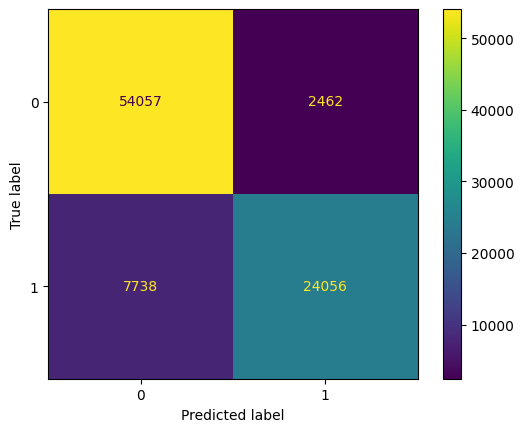

Validation Confusion Matrix:



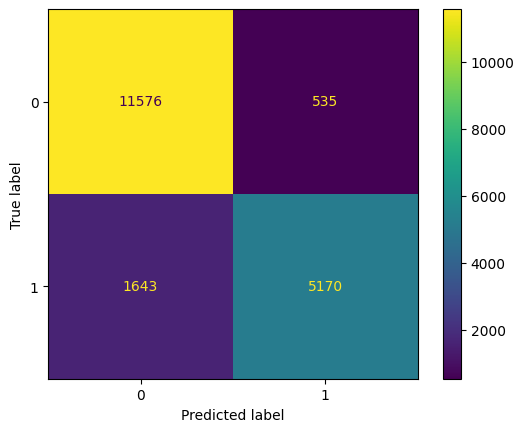

In [ ]:
# Confusion Matrix
# Training
cm_train = confusion_matrix(y_train2, train_preds, labels=svm.classes_)
disp_cm_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,

                              display_labels=svm.classes_)
print("Training Confusion Matrix:\n")
disp_cm_train.plot()
plt.show()

# Validation
cm_val = confusion_matrix(y_val2, val_preds, labels=svm.classes_)
disp_cm_val = ConfusionMatrixDisplay(confusion_matrix=cm_val,

                              display_labels=svm.classes_)
print("Validation Confusion Matrix:\n")
disp_cm_val.plot()
plt.show()

In [ ]:
# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
        estimator = train_preds,
        X = X_train_scaled2,
        response_method="predict",
        # cmap=plt.cm.Spectral,
        # alpha=0.8,
        class_of_interest = "Human"
        xlabel="Human",
        ylabel="AI",
    )

# Scatter plot
plt.scatter(X_train_scaled2[:, 0], X_train_scaled2[:, 1],
            c=y_train2,
            s=20, edgecolors="k")
plt.show()


TypeError: <module 'sklearn.svm' from '/usr/local/lib/python3.11/dist-packages/sklearn/svm/__init__.py'> is not an estimator instance.